In [ ]:
# see if this tokenizer improves with w2v

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/301_project


/content/drive/.shortcut-targets-by-id/1MYdHZqeVKSuQzIzZWrfBqMgi2EgY91a0/301_project


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:

val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [ ]:
train_texts[0]

'I should explain that as far as this trend goes for ripping off Asian horror movies, this Shutter is a head above The Grudge, and Dark Water, while still not achieving the same amount of atmospheric creepiness that The Ring establishes.<br /><br />Still though movies, like life, don\'t exist in a vacuum and are therefore up for comparison to other suspense/thriller/horror movies. Honestly, I\'m not writing a lengthy synopsis here and will say that this movie attempts to rely on music induced "startle" scares rather than atmosphere and the "ghost" itself really isn\'t that remarkable. The plot is pretty basic and predictable and isn\'t anything to write home about either. While there are a few suspenseful scenes that border on creatively scary, most of the movie is pretty vanilla. If you enjoyed The Grudge and it\'s ilk then you might enjoy this.<br /><br />Grade: C-'

# cleaning

In [ ]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# turn a doc into clean tokens
def clean_doc(data):
  preprocessed_data = []
  for doc in data:
    # split into tokens by white space
    doc=doc.lower()
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)

    preprocessed_data.append(tokens)

  return preprocessed_data

In [ ]:
X_train = clean_doc(train_texts)
X_val = clean_doc(val_texts)
X_test=clean_doc(test_texts)


In [ ]:
print(len(X_train), len(X_val), len(X_test))

35000 7499 7499


In [ ]:
X_train[0]


'rate movie skulls coz girls knew scream couldve better movie actors better twins ok believed evil eldest youngest brother sucked really bad seemed like reading scripts instead acting spoiler theyre vampires freeze blood vampires cant drink frozen blood sister movie says lets drink alivebut theyre moving another house take cooler theyre frozen blood end spoilerbr br huge waste time made mad coz read reviews movie great many awards movie movie fing st'

In [ ]:
len(X_train)

35000

# Tokenize and padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# fit a tokenizer
def create_tokenizer(lines,NUM_WORDS):
	tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
# padding
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [ ]:
# create tokenizer
NUM_WORDS=20000

tokenizer = create_tokenizer(X_train,NUM_WORDS)

# calculate max document length
length = max_length(X_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# pad data
X_train = encode_text(tokenizer, X_train, length)
X_val = encode_text(tokenizer, X_val, length)
X_test = encode_text(tokenizer, X_test, length)
print(X_train.shape)

Max document length: 1423
Vocabulary size: 143265
(35000, 1423)


# process y

In [ ]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [ ]:
word_index=tokenizer.word_index
len(word_index)

143264

# use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word doesnt not in w2v
word didnt not in w2v
word isnt not in w2v
word wasnt not in w2v
word itbr not in w2v
word moviebr not in w2v
word filmbr not in w2v
word humour not in w2v
word timebr not in w2v
word hasnt not in w2v
word shouldnt not in w2v
word favourite not in w2v
word theatre not in w2v
word thembr not in w2v
word lowbudget not in w2v
word hitchcock not in w2v
word thisbr not in w2v
word allbr not in w2v
word onebr not in w2v
word thatbr not in w2v
word himbr not in w2v
word mebr not in w2v
word wellbr not in w2v
word bmovie not in w2v
word storybr not in w2v
word tarzan not in w2v
word aint not in w2v
word keaton not in w2v
word endbr not in w2v
word overthetop not in w2v
word herebr not in w2v
word seagal not in w2v
word writerdirector not in w2v
word onbr not in w2v
word waybr not in w2v
word isbr not in w2v
word outbr not in w2v
word againbr not in w2v
word goodbr not in w2v
word welles not in w2v
word lifebr not in w2v
word wwii not in w2v
word sinatra not in w2v
word c

In [ ]:
#dump to pkl
with open('new_clean_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
import pickle as pkl

In [ ]:
# load if saevd
with open('new_clean_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.36816406e-02,  1.07910156e-01, -1.35742188e-01, ...,
        -2.13867188e-01, -8.25195312e-02, -1.68457031e-02],
       [ 1.74804688e-01, -1.09863281e-01, -2.00195312e-01, ...,
         7.95898438e-02,  2.80761719e-02, -2.02636719e-02],
       ...,
       [ 2.64658650e-01, -6.75371561e-02, -7.58862974e-01, ...,
        -9.86703001e-02,  4.44904613e-02, -5.53499180e-02],
       [-9.22851562e-02,  2.74658203e-04, -1.60156250e-01, ...,
        -1.68457031e-02, -3.14453125e-01,  1.26953125e-01],
       [ 3.01513672e-02, -4.74609375e-01, -6.64062500e-02, ...,
        -3.57421875e-01,  1.73828125e-01,  1.33666992e-02]])

In [ ]:
embedding_matrix.shape

(20000, 300)

#normal  embedding layer

In [ ]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

# define model

In [ ]:
from math import *

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Reshape,Conv2D, MaxPooling2D, Flatten, Input, concatenate, Add, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import regularizers

# train

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate,AveragePooling2D
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

In [ ]:
def simple():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(reshape)
  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)

  flatten = Flatten()(maxpool_0)

  fc2=Dense(units=84, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(flatten)
  dropout = Dropout(drop)(fc2)

  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

In [ ]:
def lenet():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(reshape)
  maxpool_0 = MaxPooling2D((2, 1), strides=(1,1))(conv_0)

  conv_1 = Conv2D(num_filters, (filter_sizes[1], 1),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(maxpool_0)
  maxpool_1 = MaxPooling2D((2, 1), strides=(1,1))(conv_1) 

  conv_2 = Conv2D(num_filters, (filter_sizes[2], 1),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(maxpool_1)
  
  flatten = Flatten()(conv_2)

  fc1=Dense(units=120, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(flatten)
  dropout = Dropout(drop)(fc1)

  fc2=Dense(units=84, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(dropout)
  dropout = Dropout(drop)(fc2)

  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=lenet()

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1423)]            0         
                                                                 
 embedding (Embedding)       (None, 1423, 100)         2000000   
                                                                 
 reshape_10 (Reshape)        (None, 1423, 100, 1)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1421, 1, 100)      30100     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1420, 1, 100)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 1417, 1, 100)      40100     
                                                           

# run model (simplest form, w2v 300)

In [ ]:
def simple():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(reshape)
  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)

  flatten = Flatten()(maxpool_0)

  fc2=Dense(units=84, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(flatten)
  dropout = Dropout(drop)(fc2)

  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=simple()

NameError: ignored

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1423)]            0         
                                                                 
 embedding (Embedding)       (None, 1423, 300)         6000000   
                                                                 
 reshape (Reshape)           (None, 1423, 300, 1)      0         
                                                                 
 conv2d (Conv2D)             (None, 1421, 1, 100)      90100     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 100)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                             

In [ ]:
from datetime import datetime
import tensorflow as tf

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './simp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.6464The average loss for epoch 0 is    0.75 and accuracy is    0.71.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.70516, saving model to ./simp/checkpoint
137/137 [==============================] - 26s 107ms/step - loss: 1.0644 - accuracy: 0.6464 - val_loss: 0.7464 - val_accuracy: 0.7052
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.7451The average loss for epoch 1 is    0.65 and accuracy is    0.75.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.70516 to 0.74503, saving model to ./simp/checkpoint
137/137 [==============================] - 14s 103ms/step - loss: 0.6742 - accuracy: 0.7451 - val_loss: 0.6528 - val_accuracy: 0.7450
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7842The average loss for epoch 2 is    0.63 and accuracy is    0.78.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.74503 

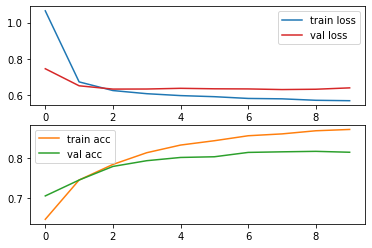

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.6249567270278931
Test accuracy: 0.8225096464157104
time:  0:00:02.741050


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.6208592057228088
Test accuracy: 0.8265101909637451
time:  0:00:02.565061


In [ ]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.8723The average loss for epoch 0 is    0.64 and accuracy is    0.81.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.81704
137/137 [==============================] - 15s 106ms/step - loss: 0.5690 - accuracy: 0.8723 - val_loss: 0.6399 - val_accuracy: 0.8100
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.8849The average loss for epoch 1 is    0.63 and accuracy is    0.82.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.81704 to 0.81784, saving model to ./simp/checkpoint
137/137 [==============================] - 15s 108ms/step - loss: 0.5561 - accuracy: 0.8849 - val_loss: 0.6335 - val_accuracy: 0.8178
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8857The average loss for epoch 2 is    0.64 and accuracy is    0.82.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.81784 to 0.81851, saving model to ./simp/c

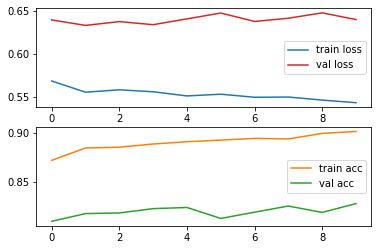

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history3 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8938The average loss for epoch 0 is    0.64 and accuracy is    0.82.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.82811
137/137 [==============================] - 17s 110ms/step - loss: 0.5536 - accuracy: 0.8938 - val_loss: 0.6423 - val_accuracy: 0.8234
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.9044The average loss for epoch 1 is    0.64 and accuracy is    0.83.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.82811
137/137 [==============================] - 15s 110ms/step - loss: 0.5404 - accuracy: 0.9044 - val_loss: 0.6375 - val_accuracy: 0.8277
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.9065The average loss for epoch 2 is    0.65 and accuracy is    0.81.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.82811
137/137 [==============================] - 15s 110ms/step - loss: 0.

KeyboardInterrupt: ignored

## test

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.8096691966056824
Test accuracy: 0.6622216105461121
time:  0:00:03.798818


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5789607763290405
Test accuracy: 0.7819709181785583
time:  0:00:03.739420


# run model (lenent trainable embedding 300: leads to runtime crash of training since model's too large)

In [ ]:
from datetime import datetime
import tensorflow as tf

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './lenet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


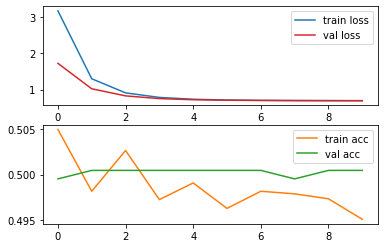

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.695830762386322
Test accuracy: 0.4995332658290863
time:  0:00:02.073112


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 1.0228345394134521
Test accuracy: 0.4995332658290863
time:  0:00:01.991484


# run model （set trainable embedding 100)

In [ ]:
from datetime import datetime
import tensorflow as tf

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './lenet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 3.1605 - accuracy: 0.5050The average loss for epoch 0 is    1.72 and accuracy is    0.50.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.49953, saving model to ./lenet/checkpoint
137/137 [==============================] - 41s 210ms/step - loss: 3.1605 - accuracy: 0.5050 - val_loss: 1.7206 - val_accuracy: 0.4995
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 1.2977 - accuracy: 0.4982The average loss for epoch 1 is    1.02 and accuracy is    0.50.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.49953 to 0.50047, saving model to ./lenet/checkpoint
137/137 [==============================] - 24s 179ms/step - loss: 1.2977 - accuracy: 0.4982 - val_loss: 1.0228 - val_accuracy: 0.5005
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.5027The average loss for epoch 2 is    0.83 and accuracy is    0.50.
LR is: 0.001

Epoch 3: val_accuracy did not improve from

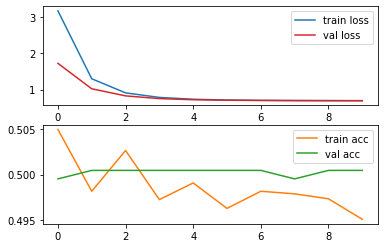

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.695830762386322
Test accuracy: 0.4995332658290863
time:  0:00:02.073112


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 1.0228345394134521
Test accuracy: 0.4995332658290863
time:  0:00:01.991484


# lenet with w2v (but with too much regularization)

## use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word doesnt not in w2v
word didnt not in w2v
word isnt not in w2v
word wasnt not in w2v
word itbr not in w2v
word moviebr not in w2v
word filmbr not in w2v
word humour not in w2v
word timebr not in w2v
word hasnt not in w2v
word shouldnt not in w2v
word favourite not in w2v
word theatre not in w2v
word thembr not in w2v
word lowbudget not in w2v
word hitchcock not in w2v
word thisbr not in w2v
word allbr not in w2v
word onebr not in w2v
word thatbr not in w2v
word himbr not in w2v
word mebr not in w2v
word wellbr not in w2v
word bmovie not in w2v
word storybr not in w2v
word tarzan not in w2v
word aint not in w2v
word keaton not in w2v
word endbr not in w2v
word overthetop not in w2v
word herebr not in w2v
word seagal not in w2v
word writerdirector not in w2v
word onbr not in w2v
word waybr not in w2v
word isbr not in w2v
word outbr not in w2v
word againbr not in w2v
word goodbr not in w2v
word welles not in w2v
word lifebr not in w2v
word wwii not in w2v
word sinatra not in w2v
word c

In [ ]:
#dump to pkl
with open('new_clean_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
import pickle as pkl

In [ ]:
# load if saevd
with open('new_clean_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.36816406e-02,  1.07910156e-01, -1.35742188e-01, ...,
        -2.13867188e-01, -8.25195312e-02, -1.68457031e-02],
       [ 1.74804688e-01, -1.09863281e-01, -2.00195312e-01, ...,
         7.95898438e-02,  2.80761719e-02, -2.02636719e-02],
       ...,
       [ 2.64658650e-01, -6.75371561e-02, -7.58862974e-01, ...,
        -9.86703001e-02,  4.44904613e-02, -5.53499180e-02],
       [-9.22851562e-02,  2.74658203e-04, -1.60156250e-01, ...,
        -1.68457031e-02, -3.14453125e-01,  1.26953125e-01],
       [ 3.01513672e-02, -4.74609375e-01, -6.64062500e-02, ...,
        -3.57421875e-01,  1.73828125e-01,  1.33666992e-02]])

In [ ]:
embedding_matrix.shape

(20000, 300)

In [ ]:
def lenet():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(reshape)
  maxpool_0 = MaxPooling2D((2, 1), strides=(1,1))(conv_0)

  conv_1 = Conv2D(num_filters, (filter_sizes[1], 1),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(maxpool_0)
  maxpool_1 = MaxPooling2D((2, 1), strides=(1,1))(conv_1) 

  conv_2 = Conv2D(num_filters, (filter_sizes[2], 1),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(maxpool_1)
  
  flatten = Flatten()(conv_2)

  fc1=Dense(units=120, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(flatten)
  dropout = Dropout(drop)(fc1)

  fc2=Dense(units=84, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(dropout)
  dropout = Dropout(drop)(fc2)

  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=lenet()

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './lenet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 2.2443 - accuracy: 0.6049The average loss for epoch 0 is    1.12 and accuracy is    0.67.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.66516, saving model to ./lenet/checkpoint
137/137 [==============================] - 31s 215ms/step - loss: 2.2443 - accuracy: 0.6049 - val_loss: 1.1200 - val_accuracy: 0.6652
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.8590 - accuracy: 0.6903The average loss for epoch 1 is    0.71 and accuracy is    0.72.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.66516 to 0.71810, saving model to ./lenet/checkpoint
137/137 [==============================] - 28s 202ms/step - loss: 0.8590 - accuracy: 0.6903 - val_loss: 0.7059 - val_accuracy: 0.7181
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7079The average loss for epoch 2 is    0.64 and accuracy is    0.72.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.7181

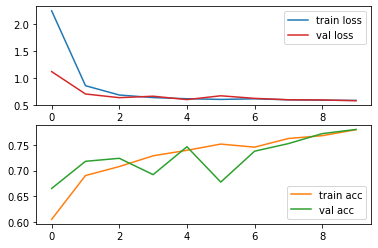

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5905583500862122
Test accuracy: 0.7685024738311768
time:  0:00:03.810143


In [ ]:
#also ahieves same performance


In [ ]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7764The average loss for epoch 0 is    0.61 and accuracy is    0.77.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.78024
137/137 [==============================] - 29s 201ms/step - loss: 0.6128 - accuracy: 0.7764 - val_loss: 0.6052 - val_accuracy: 0.7702
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8006The average loss for epoch 1 is    0.65 and accuracy is    0.74.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.78024
137/137 [==============================] - 27s 197ms/step - loss: 0.5586 - accuracy: 0.8006 - val_loss: 0.6477 - val_accuracy: 0.7400
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7985The average loss for epoch 2 is    0.63 and accuracy is    0.75.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.78024
137/137 [==============================] - 27s 194ms/step - loss: 0.

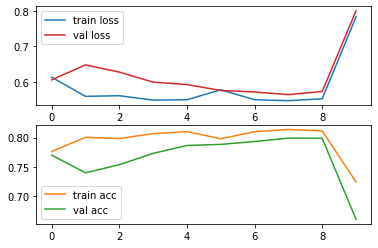

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

## test

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.8096691966056824
Test accuracy: 0.6622216105461121
time:  0:00:03.798818


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5789607763290405
Test accuracy: 0.7819709181785583
time:  0:00:03.739420


# lenet with w2v (but with less regularizations)

## use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word doesnt not in w2v
word didnt not in w2v
word isnt not in w2v
word wasnt not in w2v
word itbr not in w2v
word moviebr not in w2v
word filmbr not in w2v
word humour not in w2v
word timebr not in w2v
word hasnt not in w2v
word shouldnt not in w2v
word favourite not in w2v
word theatre not in w2v
word thembr not in w2v
word lowbudget not in w2v
word hitchcock not in w2v
word thisbr not in w2v
word allbr not in w2v
word onebr not in w2v
word thatbr not in w2v
word himbr not in w2v
word mebr not in w2v
word wellbr not in w2v
word bmovie not in w2v
word storybr not in w2v
word tarzan not in w2v
word aint not in w2v
word keaton not in w2v
word endbr not in w2v
word overthetop not in w2v
word herebr not in w2v
word seagal not in w2v
word writerdirector not in w2v
word onbr not in w2v
word waybr not in w2v
word isbr not in w2v
word outbr not in w2v
word againbr not in w2v
word goodbr not in w2v
word welles not in w2v
word lifebr not in w2v
word wwii not in w2v
word sinatra not in w2v
word c

In [ ]:
#dump to pkl
with open('new_clean_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
import pickle as pkl

In [ ]:
# load if saevd
with open('new_clean_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.36816406e-02,  1.07910156e-01, -1.35742188e-01, ...,
        -2.13867188e-01, -8.25195312e-02, -1.68457031e-02],
       [ 1.74804688e-01, -1.09863281e-01, -2.00195312e-01, ...,
         7.95898438e-02,  2.80761719e-02, -2.02636719e-02],
       ...,
       [ 2.64658650e-01, -6.75371561e-02, -7.58862974e-01, ...,
        -9.86703001e-02,  4.44904613e-02, -5.53499180e-02],
       [-9.22851562e-02,  2.74658203e-04, -1.60156250e-01, ...,
        -1.68457031e-02, -3.14453125e-01,  1.26953125e-01],
       [ 3.01513672e-02, -4.74609375e-01, -6.64062500e-02, ...,
        -3.57421875e-01,  1.73828125e-01,  1.33666992e-02]])

In [ ]:
embedding_matrix.shape

(20000, 300)

In [ ]:
def lenet():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='tanh')(reshape)
  maxpool_0 = MaxPooling2D((2, 1), strides=(1,1))(conv_0)

  conv_1 = Conv2D(num_filters, (filter_sizes[1], 1),activation='tanh')(maxpool_0)
  maxpool_1 = MaxPooling2D((2, 1), strides=(1,1))(conv_1) 

  conv_2 = Conv2D(num_filters, (filter_sizes[2], 1),activation='tanh',kernel_regularizer=regularizers.l2(0.01))(maxpool_1)
  
  flatten = Flatten()(conv_2)

  fc1=Dense(units=120, activation='tanh')(flatten)
  dropout = Dropout(drop)(fc1)

  fc2=Dense(units=84, activation='tanh',kernel_regularizer=regularizers.l2(0.01))(dropout)
  dropout = Dropout(drop)(fc2)

  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=lenet()

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './lenet_less_reg/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 1.8196 - accuracy: 0.5807The average loss for epoch 0 is    1.18 and accuracy is    0.62.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.62328, saving model to ./lenet_less_reg/checkpoint
137/137 [==============================] - 27s 189ms/step - loss: 1.8196 - accuracy: 0.5807 - val_loss: 1.1792 - val_accuracy: 0.6233
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.6960The average loss for epoch 1 is    0.71 and accuracy is    0.69.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.62328 to 0.68689, saving model to ./lenet_less_reg/checkpoint
137/137 [==============================] - 26s 189ms/step - loss: 0.8473 - accuracy: 0.6960 - val_loss: 0.7136 - val_accuracy: 0.6869
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.7509The average loss for epoch 2 is    0.54 and accuracy is    0.77.
LR is: 0.001

Epoch 3: val_accuracy im

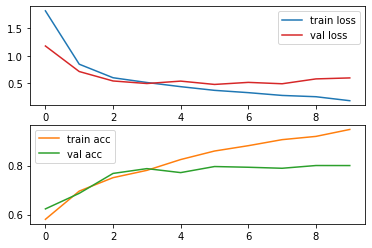

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9352The average loss for epoch 0 is    0.59 and accuracy is    0.80.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.80051
137/137 [==============================] - 27s 189ms/step - loss: 0.2229 - accuracy: 0.9352 - val_loss: 0.5914 - val_accuracy: 0.7974
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9593The average loss for epoch 1 is    0.68 and accuracy is    0.80.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.80051
137/137 [==============================] - 26s 189ms/step - loss: 0.1560 - accuracy: 0.9593 - val_loss: 0.6752 - val_accuracy: 0.8004
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9679The average loss for epoch 2 is    0.77 and accuracy is    0.79.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.80051
137/137 [==============================] - 26s 186ms/step - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.584899365901947
Test accuracy: 0.8042405843734741
time:  0:00:05.170355


In [ ]:
#also ahieves same performance


In [ ]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7764The average loss for epoch 0 is    0.61 and accuracy is    0.77.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.78024
137/137 [==============================] - 29s 201ms/step - loss: 0.6128 - accuracy: 0.7764 - val_loss: 0.6052 - val_accuracy: 0.7702
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8006The average loss for epoch 1 is    0.65 and accuracy is    0.74.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.78024
137/137 [==============================] - 27s 197ms/step - loss: 0.5586 - accuracy: 0.8006 - val_loss: 0.6477 - val_accuracy: 0.7400
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7985The average loss for epoch 2 is    0.63 and accuracy is    0.75.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.78024
137/137 [==============================] - 27s 194ms/step - loss: 0.

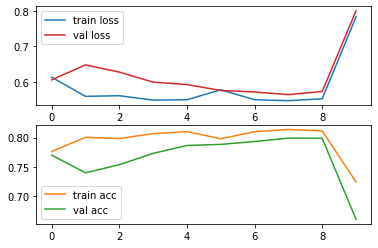

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

## test

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.8096691966056824
Test accuracy: 0.6622216105461121
time:  0:00:03.798818


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5789607763290405
Test accuracy: 0.7819709181785583
time:  0:00:03.739420
